In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.layers import *
import matplotlib.pyplot as plt
from ast import literal_eval
from keras.preprocessing import sequence
import nltk
nltk.download('stopwords')
import functions

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Načtení a rozdělení dat

In [2]:
data = pd.read_csv('clean_data.csv', converters={'Lyrics': literal_eval})

In [3]:
X = data['Lyrics']
y = data['Genre']

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify = y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42, stratify = y_train)

In [5]:
display(X_train.shape)
display(y_train.shape)
display(X_val.shape)
display(y_val.shape)
display(X_test.shape)
display(y_test.shape)

(7587,)

(7587,)

(2530,)

(2530,)

(3373,)

(3373,)

# Embedding

Zkoušel jsem předtrénovaný embedding Glove, ale výsledky byly velmi špatné, zvolil jsem tedy trénovatelnou vrstvu Embedding.

In [6]:
vocab = functions.create_vocab(X_train)

In [7]:
vocabSize = len(vocab)

In [8]:
# creates representations where every word is an integer of given data
def integer_encoding(data):
  newData = []
  for text in data:
    newText = []
    for word in text:
      if word not in vocab:
        newText.append(1) # 1 is for word which is not in vocabulary
      if word in vocab and vocab[word] > 0: # 0 is for empty word, we dont want that, 0 will be for padding
        newText.append(vocab[word] + 1)
    newData.append(newText)
  return newData

In [9]:
X_train = integer_encoding(X_train)
X_val = integer_encoding(X_val)
X_test = integer_encoding(X_test)

# Reprezentace vysvětlované proměnné

In [10]:
y_train = y_train.apply(lambda x: functions.genre_to_class[x])
y_val = y_val.apply(lambda x: functions.genre_to_class[x])
y_test = y_test.apply(lambda x: functions.genre_to_class[x])

# Padding

In [11]:
# counts maximum length of given data
def max_len(data):
  maxLen = 0
  for text in data:
    if len(text) > maxLen:
      maxLen = len(text)
  return maxLen

In [12]:
maxLen = max_len(X_train)

Přidání nul na začátek do maximální délky

In [13]:
X_train = sequence.pad_sequences(X_train, maxLen)
X_val = sequence.pad_sequences(X_val, maxLen)
X_test = sequence.pad_sequences(X_test, maxLen)

# RNN

Experimentoval jsem s různými dimenzemi embeddingu, ale rozdíly byly minimální. Zkoušel jsem použít 2 lstm vrstvy, ale validační přesnosti to nepomohlo.

In [14]:
def func_model():
  input_layer = Input(shape=(None,), dtype="int64")
  embedding = Embedding(vocabSize + 1, 64)(input_layer)
  lstm = LSTM(64)(embedding)
  output_layer = Dense(5, activation="softmax")(lstm)
  model = Model(inputs=input_layer, outputs=output_layer)
  return model

In [15]:
modelRNN = func_model()

In [16]:
modelRNN.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 64)          2205632   
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 5)                 325       
                                                                 
Total params: 2,238,981
Trainable params: 2,238,981
Non-trainable params: 0
_________________________________________________________________


Použil jsem checkpoint pro načtení vah při nejvyšší validační přesnosti.

In [17]:
mc = tf.keras.callbacks.ModelCheckpoint('./weights_RNN_best.h5',
                                     monitor='val_accuracy',
                                     save_weights_only=True,
                                     save_best_only=True)

In [18]:
modelRNN.compile(loss="sparse_categorical_crossentropy",optimizer="rmsprop",metrics=['accuracy'])

Model jsem nechal trénovat 50 epoch.

In [19]:
history = modelRNN.fit(X_train, y_train,
                    epochs=50,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose = 1,
                    callbacks=[mc])

Epoch 1/50
30/30 [==============================] - 15s 292ms/step - loss: 1.6103 - accuracy: 0.2999 - val_loss: 1.5258 - val_accuracy: 0.3783
Epoch 2/50
30/30 [==============================] - 7s 236ms/step - loss: 1.3735 - accuracy: 0.4282 - val_loss: 1.3547 - val_accuracy: 0.4289
Epoch 3/50
30/30 [==============================] - 7s 231ms/step - loss: 1.3476 - accuracy: 0.4774 - val_loss: 1.2866 - val_accuracy: 0.4514
Epoch 4/50
30/30 [==============================] - 7s 226ms/step - loss: 1.1562 - accuracy: 0.5310 - val_loss: 1.2691 - val_accuracy: 0.4664
Epoch 5/50
30/30 [==============================] - 7s 222ms/step - loss: 1.0324 - accuracy: 0.5872 - val_loss: 1.2851 - val_accuracy: 0.4419
Epoch 6/50
30/30 [==============================] - 7s 222ms/step - loss: 0.9571 - accuracy: 0.6186 - val_loss: 1.3349 - val_accuracy: 0.4771
Epoch 7/50
30/30 [==============================] - 7s 227ms/step - loss: 0.9050 - accuracy: 0.6482 - val_loss: 1.3031 - val_accuracy: 0.4771
Epoch

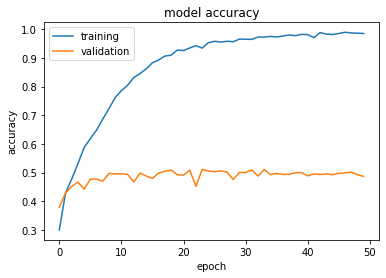

In [20]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [21]:
modelRNN.load_weights('weights_RNN_best.h5')

Funkce na predikování

In [22]:
def predict_genre(model, songs):
  songs = functions.clean_data(songs)
  songs = functions.split_data(songs)
  songs = functions.stem(songs)
  songs = functions.remove_stopwords(songs)
  songs = integer_encoding(songs)
  songs = sequence.pad_sequences(songs, maxLen)
  return model.predict(songs)

Predikce hip-hopové písničky Eminem - The way I am

In [23]:
predict_genre(modelRNN, ['Man, whatever\nDre, just let it run\nAyo, turn the beat up a little bit\nAyo, this song is for anyone...\nFuck it, just shut up and listen, ayo\nI sit back with this pack of Zig-Zags and this bag\nOf this weed, it gives me the shit needed to be\nThe most meanest MC on this on this Earth\nAnd since birth I\'ve been cursed with this curse to just curse\nAnd just blurt this berserk and bizarre shit that works\nAnd it sells and it helps in itself to relieve all this tension\nDispensing these sentences, getting this stress\nThat\'s been eating me recently off of this chest\nAnd I rest again peacefully\nBut at least have the decency in you\nTo leave me alone, when you freaks see me out\nIn the streets when I\'m eating or feeding my daughter\nTo not come and speak to me\nI don\'t know you, and no, I don\'t owe you a mothafuckin\' thing\nI\'m not Mr. N\'Sync, I\'m not what your friends think\nI\'m not Mr. Friendly, I can be a prick if you tempt me\nMy tank is on empty, no patience is in me\nAnd if you offend me, I\'m lifting you ten feet in the air\nI don\'t care who was there and who saw me just jaw you\nGo call you a lawyer, file you a lawsuit\nI\'ll smile in the courtroom and buy you a wardrobe\nI\'m tired of all you, I don\'t mean to be mean\nBut that\'s all I can be, it\'s just me\nAnd I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am, huh\nI don\'t know, it\'s just the way I am\nSometimes I just feel like my father\nI hate to be bothered with all of this nonsense, it\'s constant\nAnd, oh, it\'s his lyrical content, the song Guilty Conscience\nHas gotten such rotten responses\nAnd all of this controversy circles me\nAnd it seems like the media immediately points a finger at me\nSo I point one back at \'em, but not the index or pinkie\nOr the ring or the thumb, it\'s the one you put up\nWhen you don\'t give a fuck, when you won\'t just put up\nWith the bullshit they pull, \'cause they full of shit too\nWhen a dude\'s getting bullied and shoots up his school\nAnd they blame it on Marilyn and the heroin\nWhere were the parents at? And look where it\'s at!\nMiddle America, now it\'s a tragedy\nNow it\'s so sad to see, an upper-class city\nHavin\' this happenin\'\nThen attack Eminem \'cause I rap this way\nBut I\'m glad, \'cause they feed me the fuel that I need\nFor the fire to burn and it\'s burning, and I have returned\nAnd I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nI don\'t know, it\'s just the way I am\nI\'m so sick and tired of being admired\nThat I wish that I would just die or get fired\nAnd dropped from my label, let\'s stop with the fables\nI\'m not gonna be able to top on "My Name Is"\nAnd pigeon-holed into some poppy sensation\nTo cop me rotation at rock-n-roll stations\nAnd I just do not got the patience\nTo deal with these cocky Caucasians\nWho think I\'m some wigger who just tries to be black\n\'Cause I talk with an accent, and grab on my balls\nSo they always keep asking the same fucking questions\nWhat school did I go to, what hood I grew up in\nThe why, the who, what, when, the where and the how\n\'Til I\'m grabbing my hair and I\'m tearin\' it out\n\'Cause they driving me crazy, I can\'t take it\nI\'m racin\', I\'m pacin\', I stand and I sit\nAnd I\'m thankful for every fan that I get\nBut I can\'t take a shit in the bathroom\nWithout someone standing by it\nNo, I won\'t sign you an autograph\nYou can call me an asshole, I\'m glad, \'cause...\nI am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nI don\'t know, it\'s just the way I am'])

array([[5.9026445e-04, 3.0977296e-04, 1.2755209e-03, 2.0906245e-03,
        9.9573380e-01]], dtype=float32)

Hip-hopu odpovídá poslední neuron, model tedy predikuje správně.

# CNN

Experimentoval jsem s různými strukturami sítě, ale kvalita výsledků se příliš neměnila. Pro snížení přeučení jsem použil dropout.

In [24]:
def func_model():
  input_layer = Input(shape=(None,), dtype="int64")
  embedding = Embedding(vocabSize + 1, 64)(input_layer)
  conv1 = Conv1D(128, 5, activation="relu")(embedding)
  pool1 = MaxPooling1D(5)(conv1)
  conv2 = Conv1D(128, 5, activation="relu")(pool1)
  pool2 = MaxPooling1D(5)(conv2)
  conv3 = Conv1D(128, 5, activation="relu")(pool2)
  g_pool = GlobalMaxPooling1D()(conv3)
  dense1 = Dense(128, activation="relu")(g_pool)
  dropout = Dropout(0.2)(dense1)
  output_layer = Dense(5, activation="softmax")(dropout)
  model = Model(inputs=input_layer, outputs=output_layer)
  return model

In [25]:
modelCNN = func_model()

In [26]:
modelCNN.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding_1 (Embedding)     (None, None, 64)          2205632   
                                                                 
 conv1d (Conv1D)             (None, None, 128)         41088     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, None, 128)        0         
 1D)                                                       

Použil jsem checkpoint pro načtení vah při nejvyšší validační přesnosti.

In [27]:
mc = tf.keras.callbacks.ModelCheckpoint('./weights_CNN_best.h5',
                                     monitor='val_accuracy',
                                     save_weights_only=True,
                                     save_best_only=True)

In [28]:
modelCNN.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Model jsem nechal trénovat 50 epoch.

In [29]:
history = modelCNN.fit(X_train, y_train,
                    epochs=50,
                    batch_size=256,
                    validation_data=(X_val, y_val),
                    verbose = 1,
                    callbacks=[mc])

Epoch 1/50
30/30 [==============================] - 9s 207ms/step - loss: 1.5405 - accuracy: 0.2875 - val_loss: 1.4417 - val_accuracy: 0.3304
Epoch 2/50
30/30 [==============================] - 5s 175ms/step - loss: 1.3845 - accuracy: 0.3687 - val_loss: 1.4117 - val_accuracy: 0.3372
Epoch 3/50
30/30 [==============================] - 5s 174ms/step - loss: 1.2593 - accuracy: 0.4472 - val_loss: 1.3359 - val_accuracy: 0.3921
Epoch 4/50
30/30 [==============================] - 5s 174ms/step - loss: 1.1592 - accuracy: 0.5009 - val_loss: 1.2947 - val_accuracy: 0.4332
Epoch 5/50
30/30 [==============================] - 5s 174ms/step - loss: 1.0475 - accuracy: 0.5504 - val_loss: 1.2843 - val_accuracy: 0.4581
Epoch 6/50
30/30 [==============================] - 5s 174ms/step - loss: 0.9532 - accuracy: 0.5934 - val_loss: 1.3124 - val_accuracy: 0.4767
Epoch 7/50
30/30 [==============================] - 5s 173ms/step - loss: 0.8435 - accuracy: 0.6586 - val_loss: 1.3971 - val_accuracy: 0.4565
Epoch 

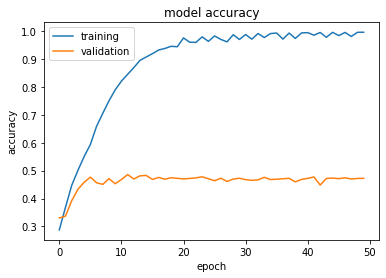

In [30]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['training', 'validation'], loc='best')
plt.show()

In [31]:
modelCNN.load_weights('weights_CNN_best.h5')

Predikce hip-hopové písničky Eminem - The way I am

In [32]:
predict_genre(modelCNN, ['Man, whatever\nDre, just let it run\nAyo, turn the beat up a little bit\nAyo, this song is for anyone...\nFuck it, just shut up and listen, ayo\nI sit back with this pack of Zig-Zags and this bag\nOf this weed, it gives me the shit needed to be\nThe most meanest MC on this on this Earth\nAnd since birth I\'ve been cursed with this curse to just curse\nAnd just blurt this berserk and bizarre shit that works\nAnd it sells and it helps in itself to relieve all this tension\nDispensing these sentences, getting this stress\nThat\'s been eating me recently off of this chest\nAnd I rest again peacefully\nBut at least have the decency in you\nTo leave me alone, when you freaks see me out\nIn the streets when I\'m eating or feeding my daughter\nTo not come and speak to me\nI don\'t know you, and no, I don\'t owe you a mothafuckin\' thing\nI\'m not Mr. N\'Sync, I\'m not what your friends think\nI\'m not Mr. Friendly, I can be a prick if you tempt me\nMy tank is on empty, no patience is in me\nAnd if you offend me, I\'m lifting you ten feet in the air\nI don\'t care who was there and who saw me just jaw you\nGo call you a lawyer, file you a lawsuit\nI\'ll smile in the courtroom and buy you a wardrobe\nI\'m tired of all you, I don\'t mean to be mean\nBut that\'s all I can be, it\'s just me\nAnd I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am, huh\nI don\'t know, it\'s just the way I am\nSometimes I just feel like my father\nI hate to be bothered with all of this nonsense, it\'s constant\nAnd, oh, it\'s his lyrical content, the song Guilty Conscience\nHas gotten such rotten responses\nAnd all of this controversy circles me\nAnd it seems like the media immediately points a finger at me\nSo I point one back at \'em, but not the index or pinkie\nOr the ring or the thumb, it\'s the one you put up\nWhen you don\'t give a fuck, when you won\'t just put up\nWith the bullshit they pull, \'cause they full of shit too\nWhen a dude\'s getting bullied and shoots up his school\nAnd they blame it on Marilyn and the heroin\nWhere were the parents at? And look where it\'s at!\nMiddle America, now it\'s a tragedy\nNow it\'s so sad to see, an upper-class city\nHavin\' this happenin\'\nThen attack Eminem \'cause I rap this way\nBut I\'m glad, \'cause they feed me the fuel that I need\nFor the fire to burn and it\'s burning, and I have returned\nAnd I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nI don\'t know, it\'s just the way I am\nI\'m so sick and tired of being admired\nThat I wish that I would just die or get fired\nAnd dropped from my label, let\'s stop with the fables\nI\'m not gonna be able to top on "My Name Is"\nAnd pigeon-holed into some poppy sensation\nTo cop me rotation at rock-n-roll stations\nAnd I just do not got the patience\nTo deal with these cocky Caucasians\nWho think I\'m some wigger who just tries to be black\n\'Cause I talk with an accent, and grab on my balls\nSo they always keep asking the same fucking questions\nWhat school did I go to, what hood I grew up in\nThe why, the who, what, when, the where and the how\n\'Til I\'m grabbing my hair and I\'m tearin\' it out\n\'Cause they driving me crazy, I can\'t take it\nI\'m racin\', I\'m pacin\', I stand and I sit\nAnd I\'m thankful for every fan that I get\nBut I can\'t take a shit in the bathroom\nWithout someone standing by it\nNo, I won\'t sign you an autograph\nYou can call me an asshole, I\'m glad, \'cause...\nI am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nRadio won\'t even play my jam\n\'Cause I am whatever you say I am\nIf I wasn\'t, then why would I say I am?\nIn the paper, the news, every day I am\nI don\'t know, it\'s just the way I am'])

array([[2.1418872e-11, 4.0789537e-08, 2.4783168e-20, 6.7744495e-06,
        9.9999321e-01]], dtype=float32)

Model predikuj správně.